## 1. Import libraries

In [94]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display Setting

In [2]:
pd.set_option("display.max_columns",None)

In [3]:
#sklearn will return dataframe
sklearn.set_config(transform_output= "pandas") 

In [4]:
# warnings.filterwarnings("ignore")

## 3.Read the data

In [5]:
file_path = r"/Users/sudhirjoon/Library/Mobile Documents/com~apple~CloudDocs/Uni_Mannheim/Nitish/Project_1_Flight_price_prediction/Data/train.csv"
train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-12,Delhi,Cochin,20:55:00,19:00:00,1325,1.0,In-flight meal not included,10262
1,Jet Airways,2019-05-27,Banglore,Delhi,15:15:00,18:10:00,175,0.0,In-flight meal not included,3502
2,Jet Airways,2019-04-01,Kolkata,Banglore,20:25:00,18:00:00,1295,1.0,No Info,11467
3,Jet Airways,2019-04-01,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,10953
4,Spicejet,2019-04-01,Banglore,Delhi,05:55:00,08:35:00,160,0.0,No check-in baggage included,3919
...,...,...,...,...,...,...,...,...,...,...
635,Air India,2019-04-24,Banglore,Delhi,13:20:00,16:10:00,170,0.0,No Info,6121
636,Indigo,2019-04-01,Mumbai,Hyderabad,09:10:00,10:40:00,90,0.0,No Info,3342
637,Indigo,2019-06-27,Chennai,Kolkata,14:45:00,17:05:00,140,0.0,No Info,3597
638,Indigo,2019-03-06,Mumbai,Hyderabad,02:30:00,04:00:00,90,0.0,No Info,3175


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
X_train = train.drop(columns= "price")
y_train = train.price.copy()

## 4. Transformation Operations

### 4.1 airline

In [8]:
X_train.airline

0      Jet Airways
1      Jet Airways
2      Jet Airways
3      Jet Airways
4         Spicejet
          ...     
635      Air India
636         Indigo
637         Indigo
638         Indigo
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [9]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

In [10]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0
636,0.0,1.0,0.0,0.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,1.0,0.0,0.0,0.0


#### 4.2 date_of_journey

In [13]:
X_train.date_of_journey

0      2019-06-12
1      2019-05-27
2      2019-04-01
3      2019-04-01
4      2019-04-01
          ...    
635    2019-04-24
636    2019-04-01
637    2019-06-27
638    2019-03-06
639    2019-06-06
Name: date_of_journey, Length: 640, dtype: object

In [28]:
feature_to_extract = ["month","week","day_of_week","day_of_year"]
doj_transformer = Pipeline(steps = [
    ("dt", DatetimeFeatures(features_to_extract = feature_to_extract, yearfirst = True, format = "mixed")),
    ("scaler",MinMaxScaler())
])
doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.882353,0.333333,0.872881
1,0.666667,0.764706,0.000000,0.737288
2,0.333333,0.294118,0.000000,0.262712
3,0.333333,0.294118,0.000000,0.262712
4,0.333333,0.294118,0.000000,0.262712
...,...,...,...,...
635,0.333333,0.470588,0.333333,0.457627
636,0.333333,0.294118,0.000000,0.262712
637,1.000000,1.000000,0.500000,1.000000
638,0.000000,0.058824,0.333333,0.042373


### 4.3 Source & destination

In [30]:
X_train.source

0         Delhi
1      Banglore
2       Kolkata
3       Kolkata
4      Banglore
         ...   
635    Banglore
636      Mumbai
637     Chennai
638      Mumbai
639       Delhi
Name: source, Length: 640, dtype: object

In [31]:
X_train.destination

0         Cochin
1          Delhi
2       Banglore
3       Banglore
4          Delhi
         ...    
635        Delhi
636    Hyderabad
637      Kolkata
638    Hyderabad
639       Cochin
Name: destination, Length: 640, dtype: object

In [33]:
location_subset = X_train.loc[:, ["source","destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Banglore,Delhi
2,Kolkata,Banglore
3,Kolkata,Banglore
4,Banglore,Delhi
...,...,...
635,Banglore,Delhi
636,Mumbai,Hyderabad
637,Chennai,Kolkata
638,Mumbai,Hyderabad


In [38]:
#feature eng 1
location_pipe1 = Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol = 0.1 , replace_with= "other", n_categories= 2)),
    ("encoder",MeanEncoder()),
    ("scaler", PowerTransformer())

])

location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,0.919922,0.920491
1,-1.114170,-1.858790
2,0.148166,0.161202
3,0.148166,0.161202
4,-1.114170,-1.858790
...,...,...
635,-1.114170,-1.858790
636,-1.888971,-1.188332
637,-1.888971,-1.188332
638,-1.888971,-1.188332


In [39]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [45]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities =  ["Delhi", "New Delhi","Kolkata","Mumbai"]
    return(
        X
        .assign(**{
            f"{col}_is_north" : X.loc[:,col].isin(north_cities).astype(int)
            for col in columns 
        })
        .drop(columns = columns)
    )

# is_north(location_subset)

#feature engg 2
FunctionTransformer(func= is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
635,0,1
636,1,0
637,0,1
638,1,0


In [48]:
#combinging multiple feature union steps

# steps feature eng1 and eng2
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func= is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,0.919922,0.920491,1,0
1,-1.114170,-1.858790,0,1
2,0.148166,0.161202,1,0
3,0.148166,0.161202,1,0
4,-1.114170,-1.858790,0,1
...,...,...,...,...
635,-1.114170,-1.858790,0,1
636,-1.888971,-1.188332,1,0
637,-1.888971,-1.188332,0,1
638,-1.888971,-1.188332,1,0


#### 4.4 Dept Time & Arrival Time

In [50]:
X_train.dep_time

0      20:55:00
1      15:15:00
2      20:25:00
3      09:35:00
4      05:55:00
         ...   
635    13:20:00
636    09:10:00
637    14:45:00
638    02:30:00
639    07:05:00
Name: dep_time, Length: 640, dtype: object

In [51]:
X_train.arrival_time

0      19:00:00
1      18:10:00
2      18:00:00
3      21:05:00
4      08:35:00
         ...   
635    16:10:00
636    10:40:00
637    17:05:00
638    04:00:00
639    19:00:00
Name: arrival_time, Length: 640, dtype: object

In [53]:
time_subset = X_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,20:55:00,19:00:00
1,15:15:00,18:10:00
2,20:25:00,18:00:00
3,09:35:00,21:05:00
4,05:55:00,08:35:00
...,...,...
635,13:20:00,16:10:00
636,09:10:00,10:40:00
637,14:45:00,17:05:00
638,02:30:00,04:00:00


In [56]:
time_pipe1 = Pipeline(steps= [
    ("dt", DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler",MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

/Users/sudhirjoon/Library/Python/3.9/lib/python/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Users/sudhirjoon/Library/Python/3.9/lib/python/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.863636,1.000000,0.826087,0.000000
1,0.636364,0.272727,0.782609,0.181818
2,0.863636,0.454545,0.782609,0.000000
3,0.363636,0.636364,0.913043,0.090909
4,0.181818,1.000000,0.347826,0.636364
...,...,...,...,...
635,0.545455,0.363636,0.695652,0.181818
636,0.363636,0.181818,0.434783,0.727273
637,0.590909,0.818182,0.739130,0.090909
638,0.045455,0.545455,0.173913,0.000000


In [60]:
def part_of_day(X , morning = 4, noon = 12, evening = 16, night = 20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    return(
        X_temp
        .assign(**{
            f"{col} part_of_day": np.select(
                [X_temp.loc[:,col].between(morning , noon,inclusive = "left"),
                X_temp.loc[:,col].between(noon , evening,inclusive = "left"),
                X_temp.loc[:,col].between(evening , night,inclusive = "left")],
                ['morning','afternoon','evening'],
                default = "night"
            )
            for col in columns
        })
        .drop(columns = columns)
    )

FunctionTransformer(func = part_of_day).fit_transform(time_subset)


/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:,col]).dt.hour
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:,col]).dt.hour


,dep_time part_of_day,arrival_time part_of_day
0,night,evening
1,afternoon,evening
2,night,evening
3,morning,night
4,morning,morning
...,...,...
635,afternoon,evening
636,morning,morning
637,afternoon,evening
638,night,morning


In [66]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func= part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler",MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:,col]).dt.hour
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:,col]).dt.hour


,dep_time part_of_day,arrival_time part_of_day
0,0.07732,0.878788
1,0.00000,0.878788
2,0.07732,0.878788
3,1.00000,1.000000
4,1.00000,0.989899
...,...,...
635,0.00000,0.878788
636,1.00000,0.989899
637,0.00000,0.878788
638,0.07732,0.989899


In [67]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])
time_transformer.fit_transform(time_subset)

/Users/sudhirjoon/Library/Python/3.9/lib/python/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Users/sudhirjoon/Library/Python/3.9/lib/python/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:,col]).dt.hour
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: Us

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time part_of_day,arrival_time part_of_day
0,0.863636,1.000000,0.826087,0.000000,0.07732,0.878788
1,0.636364,0.272727,0.782609,0.181818,0.00000,0.878788
2,0.863636,0.454545,0.782609,0.000000,0.07732,0.878788
3,0.363636,0.636364,0.913043,0.090909,1.00000,1.000000
4,0.181818,1.000000,0.347826,0.636364,1.00000,0.989899
...,...,...,...,...,...,...
635,0.545455,0.363636,0.695652,0.181818,0.00000,0.878788
636,0.363636,0.181818,0.434783,0.727273,1.00000,0.989899
637,0.590909,0.818182,0.739130,0.090909,0.00000,0.878788
638,0.045455,0.545455,0.173913,0.000000,0.07732,0.989899


#### 4.5 Duration

In [99]:
X_train.duration

0      1325
1       175
2      1295
3       690
4       160
       ... 
635     170
636      90
637     140
638      90
639     715
Name: duration, Length: 640, dtype: int64

In [100]:
(
    X_train
    .duration
    .quantile([0.25,0.50,0.75])
    .values
    .reshape(-1,1) # n no of rows but only one column
)

array([[175.  ],
       [535.  ],
       [996.25]])

In [101]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [102]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.000000e+00,1.000000,1.000000
1,0.0,0.000000e+00,0.904837,0.904837
2,0.0,1.514753e-238,1.000000,1.000000
3,0.0,0.000000e+00,1.000000,1.000000
4,0.0,0.000000e+00,0.904837,0.904837
...,...,...,...,...
635,0.0,0.000000e+00,0.904837,0.904837
636,0.0,0.000000e+00,0.904837,0.904837
637,0.0,0.000000e+00,0.904837,0.904837
638,0.0,0.000000e+00,0.904837,0.904837


In [103]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [104]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [105]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [106]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.330408,-0.132348,-0.069319,2.0,1,1.315738
1,3.204046,-0.132348,-0.069319,0.0,0,-0.958002
2,-0.330408,-0.132348,-0.069319,2.0,1,1.256423
3,-0.330408,-0.132348,-0.069319,2.0,0,0.060238
4,-0.330408,-0.132348,-0.069319,0.0,0,-0.987660
...,...,...,...,...,...,...
635,2.946623,-0.132348,-0.069319,0.0,0,-0.967888
636,-0.330408,-0.132348,-0.069319,0.0,0,-1.126061
637,-0.330408,-0.132348,-0.069319,0.0,0,-1.027203
638,-0.330408,-0.132348,-0.069319,0.0,0,-1.126061


## 4.6 total_stops

In [108]:
X_train.total_stops

0      1.0
1      0.0
2      1.0
3      1.0
4      0.0
      ... 
635    0.0
636    0.0
637    0.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [109]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,1.0,0
3,1.0,0
4,0.0,1
...,...,...
635,0.0,1
636,0.0,1
637,0.0,1
638,0.0,1


#### 4.7 additional_info

In [110]:
X_train.additional_info

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4      No check-in baggage included
                   ...             
635                         No Info
636                         No Info
637                         No Info
638                         No Info
639     In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [111]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [112]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [113]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [114]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,0.0,1.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## 5. Column Transformer

In [115]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

/Users/sudhirjoon/Library/Python/3.9/lib/python/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Users/sudhirjoon/Library/Python/3.9/lib/python/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:,col]).dt.hour
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: Us

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time part_of_day,time__arrival_time part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,0.919922,0.920491,1,0,0.863636,1.000000,0.826087,0.000000,0.07732,0.878788,-0.330408,-0.132348,-0.069319,2.0,1,1.315738,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,-1.114170,-1.858790,0,1,0.636364,0.272727,0.782609,0.181818,0.00000,0.878788,3.204046,-0.132348,-0.069319,0.0,0,-0.958002,0.0,1,1.0,0.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,0.148166,0.161202,1,0,0.863636,0.454545,0.782609,0.000000,0.07732,0.878788,-0.330408,-0.132348,-0.069319,2.0,1,1.256423,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,0.148166,0.161202,1,0,0.363636,0.636364,0.913043,0.090909,1.00000,1.000000,-0.330408,-0.132348,-0.069319,2.0,0,0.060238,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.333333,0.294118,0.000000,0.262712,-1.114170,-1.858790,0,1,0.181818,1.000000,0.347826,0.636364,1.00000,0.989899,-0.330408,-0.132348,-0.069319,0.0,0,-0.987660,0.0,1,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0,0.333333,0.470588,0.333333,0.457627,-1.114170,-1.858790,0,1,0.545455,0.363636,0.695652,0.181818,0.00000,0.878788,2.946623,-0.132348,-0.069319,0.0,0,-0.967888,0.0,1,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,-1.888971,-1.188332,1,0,0.363636,0.181818,0.434783,0.727273,1.00000,0.989899,-0.330408,-0.132348,-0.069319,0.0,0,-1.126061,0.0,1,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,-1.888971,-1.188332,0,1,0.590909,0.818182,0.739130,0.090909,0.00000,0.878788,-0.330408,-0.132348,-0.069319,0.0,0,-1.027203,0.0,1,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-1.888971,-1.188332,1,0,0.045455,0.545455,0.173913,0.000000,0.07732,0.989899,-0.330408,-0.132348,-0.069319,0.0,0,-1.126061,0.0,1,0.0,1.0,0.0,0


## 5. Feature Selection

In [116]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Putting it all Together

In [117]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

/Users/sudhirjoon/Library/Python/3.9/lib/python/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Users/sudhirjoon/Library/Python/3.9/lib/python/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:,col]).dt.hour
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_1791/955801382.py:4: Us

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.882353,0.872881,0.919922,0.920491,-0.330408,2.0,1,1.315738,1.0,0
1,0.0,1.0,0.0,0.764706,0.737288,-1.114170,-1.858790,3.204046,0.0,0,-0.958002,0.0,1
2,0.0,1.0,0.0,0.294118,0.262712,0.148166,0.161202,-0.330408,2.0,1,1.256423,1.0,0
3,0.0,1.0,0.0,0.294118,0.262712,0.148166,0.161202,-0.330408,2.0,0,0.060238,1.0,0
4,0.0,0.0,1.0,0.294118,0.262712,-1.114170,-1.858790,-0.330408,0.0,0,-0.987660,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.470588,0.457627,-1.114170,-1.858790,2.946623,0.0,0,-0.967888,0.0,1
636,1.0,0.0,0.0,0.294118,0.262712,-1.888971,-1.188332,-0.330408,0.0,0,-1.126061,0.0,1
637,1.0,0.0,0.0,1.000000,1.000000,-1.888971,-1.188332,-0.330408,0.0,0,-1.027203,0.0,1
638,1.0,0.0,0.0,0.058824,0.042373,-1.888971,-1.188332,-0.330408,0.0,0,-1.126061,0.0,1


## 7. Visualizations

In [123]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x113076f70>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [118]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.0006581830672283129,
 'air__airline_Indigo': 0.14428180950831582,
 'air__airline_Jet Airways': 0.2239141819782422,
 'air__airline_Multiple Carriers': 0.0071810538302697164,
 'air__airline_Other': 0.11349033436555966,
 'doj__date_of_journey_month': 0.05969643127049399,
 'doj__date_of_journey_week': 0.14199030989444786,
 'doj__date_of_journey_day_of_week': -0.04077311540401648,
 'doj__date_of_journey_day_of_year': 0.18831408958514828,
 'location__source': 0.14443166802461851,
 'location__destination': 0.1427168909908296,
 'location__source_is_north': 0.05012279433244804,
 'location__destination_is_north': 0.05012279433244804,
 'time__dep_time_hour': 0.0029336079913612942,
 'time__dep_time_minute': 0.01885305527753463,
 'time__arrival_time_hour': 0.09801333382064466,
 'time__arrival_time_minute': 0.030504008620750794,
 'time__dep_time part_of_day': -0.0002215226608918893,
 'time__arrival_time part_of_day': 0.044911631428927845,
 'dur__duration_rbf_25': 0.1136

In [119]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': -0.04077311540401648,
 'info__additional_info_No Info': -0.008525273745510894,
 'info__additional_info': -0.008525273745510894,
 'air__airline_Air India': -0.0006581830672283129,
 'time__dep_time part_of_day': -0.0002215226608918893,
 'dur__duration_rbf_75': 0.000214057705751484,
 'dur__duration_rbf_50': 0.0012070385476230145,
 'info__additional_info_In-flight meal not included': 0.001815022898279987,
 'time__dep_time_hour': 0.0029336079913612942,
 'air__airline_Multiple Carriers': 0.0071810538302697164,
 'time__dep_time_minute': 0.01885305527753463,
 'time__arrival_time_minute': 0.030504008620750794,
 'time__arrival_time part_of_day': 0.044911631428927845,
 'location__source_is_north': 0.05012279433244804,
 'location__destination_is_north': 0.05012279433244804,
 'info__additional_info_Other': 0.05164977989878731,
 'doj__date_of_journey_month': 0.05969643127049399,
 'time__arrival_time_hour': 0.09801333382064466,
 'air__airline_Other': 0.11349033436

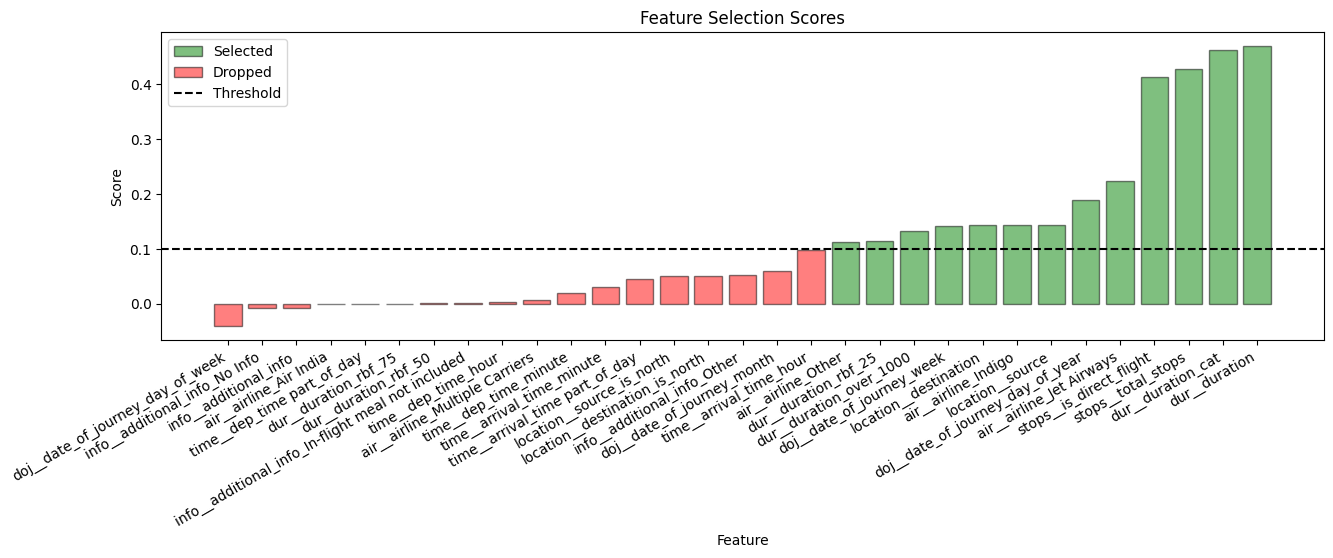

In [120]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()


- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that